## 深層学習の実習

### 訓練データとテストデータそれぞれの画像ファイルを読み込む

#### `image_dataset_from_directory()` で読み込む

In [1]:
# 訓練データとテストデータの画像を読み込む
# （サイズは縦横224pxにリサイズする）
import tensorflow as tf

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "nagaoka_gis/train",
    image_size=(224, 224),
    label_mode="binary",
    batch_size=32,
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "nagaoka_gis/test",
    image_size=(224, 224),
    label_mode="binary",
    batch_size=32,
    shuffle=False
)

Found 20 files belonging to 2 classes.
Found 6 files belonging to 2 classes.


#### データを確認する

In [2]:
# データの詳細を表示する
list(train_dataset.as_numpy_iterator())[0]

(array([[[[ 89.      , 122.      , 111.      ],
          [ 89.      , 122.      , 111.      ],
          [ 87.      , 123.      , 111.      ],
          ...,
          [ 51.45156 ,  74.45156 ,  48.45156 ],
          [ 56.6295  ,  79.6295  ,  51.6295  ],
          [ 59.318783,  82.31879 ,  54.318783]],
 
         [[ 89.      , 122.      , 111.      ],
          [ 89.      , 122.      , 111.      ],
          [ 87.      , 123.      , 111.      ],
          ...,
          [ 69.39789 ,  92.39789 ,  63.880035],
          [ 62.578712,  85.57871 ,  57.578712],
          [ 65.73213 ,  88.73213 ,  60.732132]],
 
         [[ 89.      , 122.      , 111.      ],
          [ 89.      , 122.      , 111.      ],
          [ 87.      , 123.      , 111.      ],
          ...,
          [ 54.974716,  78.08696 ,  48.750233],
          [ 60.375   ,  83.375   ,  55.375   ],
          [ 67.64544 ,  90.64544 ,  62.645435]],
 
         ...,
 
         [[ 79.28571 , 112.28571 , 101.28571 ],
          [ 80.   

In [3]:
# 分類名（no／yes）をリストとして格納する
class_names = train_dataset.class_names
class_names

['no', 'yes']

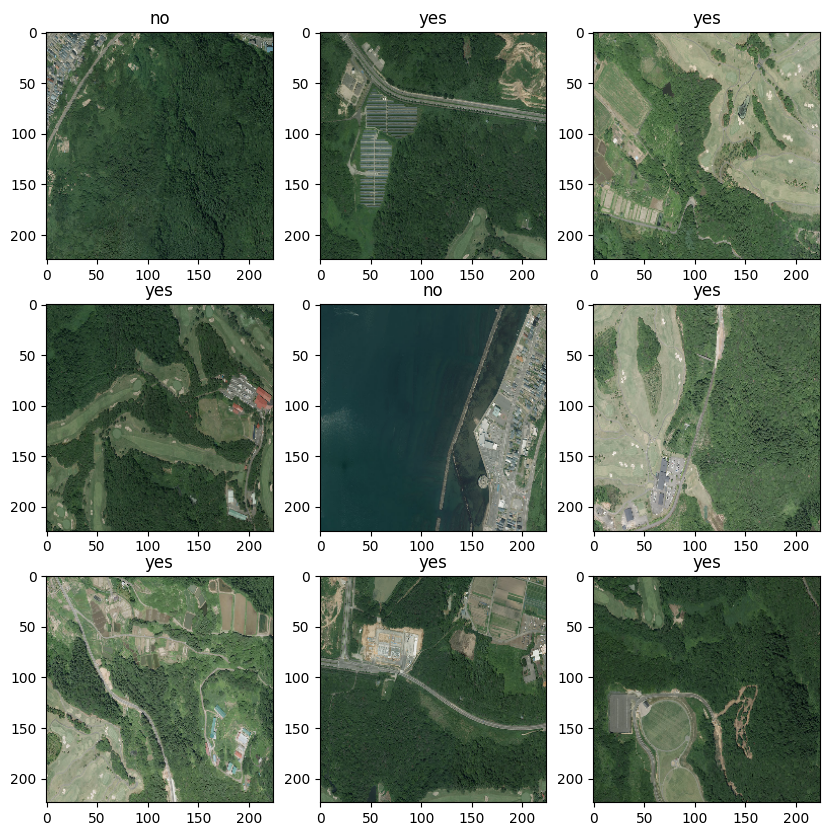

In [4]:
# 訓練データの一部を表示して確認
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])

### データの水増しを行なう

In [5]:
# 画像の水増しをする関数の定義
def flip_left_right(image, label):   # 左右反転
    image = tf.image.flip_left_right(image)
    return image, label

def flip_up_down(image, label):      # 上下反転
    image = tf.image.flip_up_down(image)
    return image, label

def rot90(image, label):             # 反時計回りに90度回転
    image = tf.image.rot90(image)
    return image, label

def rot180(image, label):            # 反時計回りに180度回転
    image = tf.image.rot90(image, k=2)
    return image, label

def rot270(image, label):            # 反時計回りに270度回転
    image = tf.image.rot90(image, k=3)
    return image, label

In [6]:
# 画像の水増し処理の実行
train_dataset_lr     = train_dataset.map(flip_left_right)
train_dataset_ud     = train_dataset.map(flip_up_down)
train_dataset_rot90  = train_dataset.map(rot90)
train_dataset_rot180 = train_dataset.map(rot180)
train_dataset_rot270 = train_dataset.map(rot270)

In [7]:
# 水増ししたデータを訓練データに追加する
train_dataset = train_dataset.concatenate(train_dataset_lr)
train_dataset = train_dataset.concatenate(train_dataset_ud)
train_dataset = train_dataset.concatenate(train_dataset_rot90)
train_dataset = train_dataset.concatenate(train_dataset_rot180)
train_dataset = train_dataset.concatenate(train_dataset_rot270)

In [8]:
# データをシャッフルする
train_dataset = train_dataset.shuffle(32)

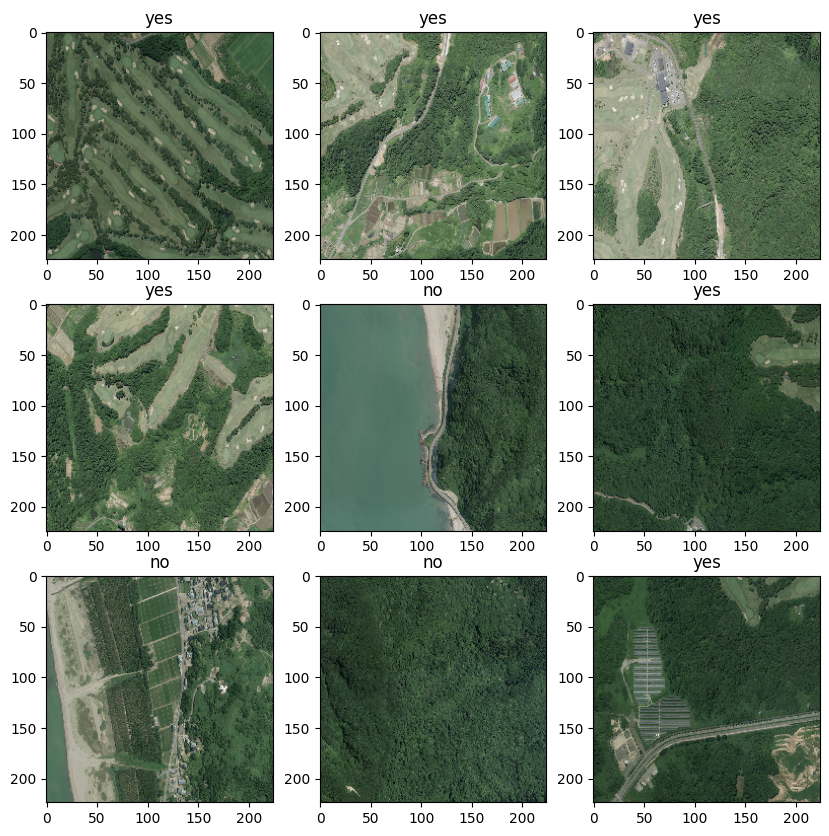

In [9]:
# 訓練データの一部を表示して確認
plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])

### モデルを作って学習する

#### MobileNetV2の学習済みモデルを読み込む

In [10]:
# MobileNetV2モデルを作成する
input_layer = tf.keras.Input(shape=(224, 224, 3))   # 入力層
l_layer = tf.keras.applications.mobilenet_v2.preprocess_input(input_layer)   # 前処理（正規化）をする層

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(224, 224, 3),
    input_tensor=l_layer,
    include_top=False,
    weights="imagenet",
    pooling='avg'
)
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### 出力層を作成する

In [11]:
# Dense層を追加する
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

#### モデルを完成させる

In [12]:
# base_modelに先ほどのDense層を追加したモデルを作成する
model = tf.keras.Sequential([
    base_model,
    output_layer
])

In [13]:
# modelをcompileする
model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=["accuracy"])

In [ ]:
# modelに学習させる
model.fit(train_dataset, epochs=20)

In [ ]:
# テストデータで分類を実行する
pred_data = model.predict(test_dataset)

In [16]:
# 分類した結果を確認する
pred_data

array([[0.04909301],
       [0.38173732],
       [0.07095545],
       [0.97917575],
       [0.7712887 ],
       [0.9834499 ]], dtype=float32)

In [17]:
# evaluate()でモデルの性能を評価する
model.evaluate(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step - accuracy: 1.0000 - loss: 0.1504


[0.15036745369434357, 1.0]